<font size=7> LFP Single Channel Analysis

# <font color="gray">Imports

import stuff

In [10]:
from braingeneers import analysis
import braingeneers.data.datasets_electrophysiology as ephys
import braingeneers.utils.smart_open_braingeneers as smart_open
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pywt
import spkit as sp   # https://spkit.github.io/
from scipy import signal, ndimage
from scipy.interpolate import interp1d
from matplotlib.colors import Normalize, LogNorm, NoNorm
from matplotlib.cm import get_cmap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import time
import pickle 

fs = 20000.0

In [2]:
from human_hip.basics import read_phy_files

# <font color="green">Attempt 3 - LFP CA1

## <font color="green"> Load data

load metadata

In [7]:
metadata = ephys.load_metadata("2023-04-02-e-hc328_unperturbed")


load spike data 

In [12]:
file = open('/workspaces/human_hippocampus/data/ephys/2023-04-02-e-hc328_unperturbed/sd_ca1_curated.pkl', 'rb')
sd = pickle.load(file)
file.close()

Get channels we want form the spike data. We create a list of all the unique channels in increasing order.

In [43]:
channels = []
for key,val in sd.neuron_data[0].items():
    channels.append( val["channel"] )
    keys.append( key )
channels = np.unique(channels).tolist()

/tmp/ipykernel_1660/4211858769.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())


Download raw data


<font color="red">Currently we get a much smaller slice of the data, later this should be replaced with the whole thing

In [50]:
metadata = ephys.load_metadata("2023-04-02-e-hc328_unperturbed")
raw_data = ephys.load_data( metadata=metadata, experiment="experiment1", length=100000, offset=2000000,  channels= [0] )

/srv/conda/envs/notebook/lib/python3.10/site-packages/braingeneers/data/datasets_electrophysiology.py:197: UserWarning: Dataset 2023-04-02-e-hc328_unperturbed is not in row-major format, the parallel data reader can't be used, read speeds may be slow over a network.
/srv/conda/envs/notebook/lib/python3.10/site-packages/braingeneers/data/datasets_electrophysiology.py:209: UserWarning: Metadata is missing the required voltage_scaling_factor attribute. Using default value of 1.0.


Save data

In [51]:
to_save = { "data":raw_data, "channels":[0] }

In [52]:
# with open( '/workspaces/human_hippocampus/data/ephys/2023-04-02-e-hc328_unperturbed/raw_data.pkl' , 'wb') as file:
#     pickle.dump(to_save, file)

check we can laod data

In [53]:
file = open('/workspaces/human_hippocampus/data/ephys/2023-04-02-e-hc328_unperturbed/raw_data.pkl', 'rb')
checkit = pickle.load(file)
file.close()

# <font color="blue"> Functions

## <font color="blue">spectrogram_plot

In [57]:
def spectrogram_plot(z, times, frequencies, coif, cmap=None, norm=Normalize(), ax=None, colorbar=True):
    ###########################################################################
    # plot
    
    # set default colormap, if none specified
    if cmap is None:
        cmap = get_cmap('Greys')
    # or if cmap is a string, get the actual object
    elif isinstance(cmap, str):
        cmap = get_cmap(cmap)

    # create the figure if needed
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = plt.gcf()

    xx,yy = np.meshgrid(times,frequencies)
    ZZ = z
    
    im = ax.pcolor(xx,yy,ZZ, norm=norm, cmap=cmap)
    # ax.plot(times,coif)
    # ax.fill_between(times,coif, step="mid", alpha=0.4)
    
    if colorbar:
        cbaxes = inset_axes(ax, width="2%", height="90%", loc=4) 
        fig.colorbar(im, cax=cbaxes, orientation='vertical')

    ax.set_xlim(times.min(), times.max())
    ax.set_ylim(frequencies.min(), frequencies.max())

    return ax

## <font color="blue">cwt_spectrogram

In [58]:
def cwt_spectrogram(x, fs, nNotes=12, detrend=True, normalize=True):
    
    N = len(x)
    dt = 1.0 / fs
    times = np.arange(N) * dt

    ###########################################################################
    # detrend and normalize
    if detrend:
        x = signal.detrend(x,type='linear')
    if normalize:
        stddev = x.std()
        x = x / stddev

    ###########################################################################
    # Define some parameters of our wavelet analysis. 

    # maximum range of scales that makes sense
    # min = 2 ... Nyquist frequency
    # max = np.floor(N/2)

    nOctaves = int(np.log2(2*np.floor(N/2.0)))
    scales = 2**np.arange(1, nOctaves, 1.0/nNotes)
    
#     print (scales)

    ###########################################################################
    # cwt and the frequencies used. 
    # Use the complex morelet with bw=1.5 and center frequency of 1.0
    coef, freqs=pywt.cwt(x, scales, 'cmor1-1')
    frequencies = pywt.scale2frequency('cmor1-1', scales) / dt
    
    ###########################################################################
    # power
#     power = np.abs(coef)**2
    power = np.abs(coef * np.conj(coef))
    
    # smooth a bit
    power = ndimage.gaussian_filter(power, sigma=2)

    ###########################################################################
    # cone of influence in frequency for cmorxx-1.0 wavelet
    f0 = 2*np.pi
    cmor_coi = 1.0 / np.sqrt(2)
    cmor_flambda = 4*np.pi / (f0 + np.sqrt(2 + f0**2))
    # cone of influence in terms of wavelength
    coi = (N / 2 - np.abs(np.arange(0, N) - (N - 1) / 2))
    coi = cmor_flambda * cmor_coi * dt * coi
    # cone of influence in terms of frequency
    coif = 1.0/coi


    return power, times, frequencies, coif

## <font color="blue"> Downsample Dataset

Create a smaller version of the data, but only keeping 1 in 20 (by default) datapoints

In [59]:
# Downsample abd remove artifact
def downsample(wav_lfp, dec=20, fs=20000.0):
    wav_data = signal.decimate(wav_lfp, dec)
    return fs/dec, wav_data


## <font color="blue">Frame Removal

In [60]:

def artifact_removal(wav_lfp):
    corrected_lfp = sp.eeg.ATAR(wav_lfp.copy(),winsize=128*8, beta=0.1, 
                      OptMode='elim', IPR=[25,75], k1=1, k2=10, verbose=0)[0, :]
    return corrected_lfp

# <font color="green">Sury Code

Set Parameters

In [61]:
N = 1000 * 40
nNotes = 12
dt = 1.0 / 1000.0
nOctaves = int(np.log2(2*np.floor(N/2.0)))
scales = 2**np.arange(1, nOctaves, 1.0/nNotes)
frequencies = pywt.scale2frequency('cmor1-1', scales) / dt
print(min(frequencies), max(frequencies))

# plot spectrogram
#figure_path = "/workspaces/human_hippocampus/data/ephys/2022-10-20-e-/"
fs = 20000.0
dec = 20
fs_down = fs/dec  # downsample from 20000Hz to 1000Hz
# @Elliott: Select a recording period that you want to plot. Example here is 60-80s
rec_period = [60, 80] # [start, end] (second)
low_cut, high_cut = 0.1, 100

0.032332247752664335 500.0


In [66]:
raw_trace = raw_data 

Plot Wave


AttributeError: module 'braingeneers.analysis' has no attribute 'butter_filter'

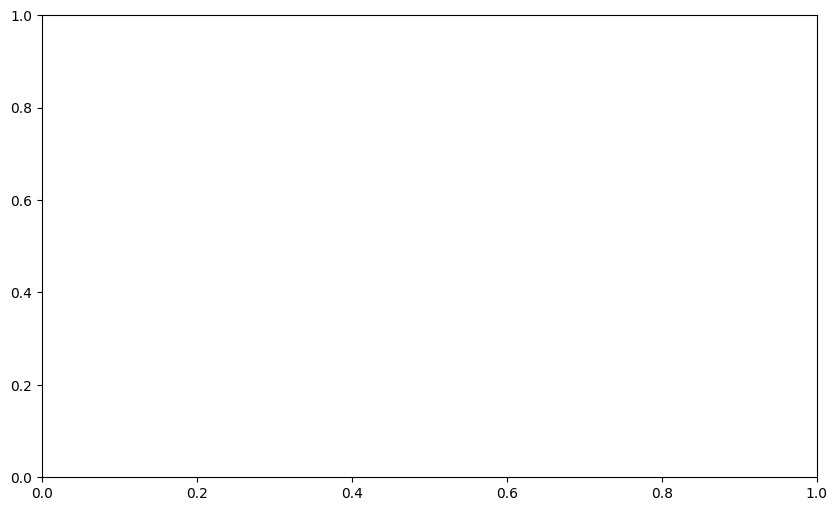

In [67]:

# @Elliott: you can save the raw_trace here if you want to. That way you don't need to load it again
#print(i, channel,raw_trace.shape)

fig, axs = plt.subplots(1, 1, figsize=(10, 6))

wav_lfp = analysis.butter_filter(raw_trace, low_cut, high_cut)
ds_lfp = downsample(wav_lfp, dec=dec)[1]
lfp_cor = artifact_removal(ds_lfp)  # This line is optional since there is no obvious artifact in this recording

power, times, frequencies, coif = cwt_spectrogram(lfp_cor, fs_down, nNotes=12)
total_duration = len(lfp_cor) / fs_down
spectrogram_plot(power, times, frequencies, coif, cmap='jet', norm=LogNorm(vmin=10e-8, vmax=10e4), ax=axs)

axs.set_title(f"spectrum", fontsize=12)
axs.set_xlim(0, total_duration)
axs.set_ylim(0, high_cut)
axs.set_xlabel('time (s)')
axs.set_ylabel('frequency (Hz)')
axs.set_yscale('log')
plt.show(block=False)
#plt.savefig(f"spectrogram.png", dpi=300)
#plt.close()

# <font color="brown">Safety Sury Code

# Setting Parameters (surry code)

Set some parametes (don't know what they do)

In [4]:
N = 1000 * 40
nNotes = 12
dt = 1.0 / 1000.0
nOctaves = int(np.log2(2*np.floor(N/2.0)))
scales = 2**np.arange(1, nOctaves, 1.0/nNotes)
frequencies = pywt.scale2frequency('cmor1-1', scales) / dt
print(min(frequencies), max(frequencies))

##  cmor0.1-0.1 what are good bw and center frequency?

0.032332247752664335 500.0


Set recording path

In [5]:
# Recording path on NRP
#rec_path = "/workspaces/human_hippocampus/data/ephys/2022-10-20-e-/original/data/hc9.19_chp-16849_plated-10.19.22_rec10.19.22.raw.h5"
#rec_path = "s3://braingeneers/ephys/2023-04-02-e-hc328_unperturbed/original/data/" \
#            "hc3.28_hckcr1_chip16835_plated34.2_rec4.2.raw.h5"

# @Elliott: input your curation data here 
#curated = "/workspaces/human_hippocampus/data/ephys/2022-10-20-e-/derived/kilosort2/hc9.19_chp-16849_plated-10.19.22_rec10.19.22_curated.zip"

#file_name = "hc9.19_chp-16849_plated-10.19.22_rec10.19.22.raw.h"

Load spike data

In [6]:
# @Elliott: load the curation
#spike_data = read_phy_files(curated)
#neuron_data = spike_data.neuron_data[0]

/tmp/ipykernel_9903/775858247.py:3: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())


Set parameter for portion of data we're interested in

In [7]:
# plot spectrogram
#figure_path = "/workspaces/human_hippocampus/data/ephys/2022-10-20-e-/"
fs = 20000.0
dec = 20
fs_down = fs/dec  # downsample from 20000Hz to 1000Hz
# @Elliott: Select a recording period that you want to plot. Example here is 60-80s
rec_period = [60, 80] # [start, end] (second)
low_cut, high_cut = 0.1, 100


## Sury Analysis

In [ ]:
for i in range(spike_data.N):
    channel = neuron_data[i]['channel']
    # @Elliott: load the raw trace using David's high performance function 
    # https://github.com/braingeneers/braingeneerspy/blob/master/braingeneers/data/datasets_electrophysiology.py#L462
    raw_trace = ephys.load_data_maxwell_parallel(metadata: dict, batch_uuid: str, experiment: str,
                               channels: Iterable[int], offset: int, length: int)
   
    # @Elliott: you can save the raw_trace here if you want to. That way you don't need to load it again
    print(i, channel,raw_trace.shape)
    
    fig, axs = plt.subplots(1, 1, figsize=(10, 6))

    wav_lfp = analysis.butter_filter(raw_trace, low_cut, high_cut)
    ds_lfp = downsample(wav_lfp, dec=dec)[1]
    lfp_cor = artifact_removal(ds_lfp)  # This line is optional since there is no obvious artifact in this recording

    power, times, frequencies, coif = cwt_spectrogram(lfp_cor, fs_down, nNotes=12)
    total_duration = len(lfp_cor) / fs_down
    spectrogram_plot(power, times, frequencies, coif, cmap='jet', norm=LogNorm(vmin=10e-8, vmax=10e4), ax=axs)

    axs.set_title(f"Unit {i} spectrum", fontsize=12)
    axs.set_xlim(0, total_duration)
    axs.set_ylim(0, high_cut)
    axs.set_xlabel('time (s)')
    axs.set_ylabel('frequency (Hz)')
    axs.set_yscale('log')
    # plt.show(block=False)
    plt.savefig(f"{figure_path}spectrogram_unit_{i}.png", dpi=300)
    plt.close()

In [ ]:
   
    # @Elliott: you can save the raw_trace here if you want to. That way you don't need to load it again
    print(i, channel,raw_trace.shape)
    
    fig, axs = plt.subplots(1, 1, figsize=(10, 6))

    wav_lfp = analysis.butter_filter(raw_trace, low_cut, high_cut)
    ds_lfp = downsample(wav_lfp, dec=dec)[1]
    lfp_cor = artifact_removal(ds_lfp)  # This line is optional since there is no obvious artifact in this recording

    power, times, frequencies, coif = cwt_spectrogram(lfp_cor, fs_down, nNotes=12)
    total_duration = len(lfp_cor) / fs_down
    spectrogram_plot(power, times, frequencies, coif, cmap='jet', norm=LogNorm(vmin=10e-8, vmax=10e4), ax=axs)

    axs.set_title(f"Unit {i} spectrum", fontsize=12)
    axs.set_xlim(0, total_duration)
    axs.set_ylim(0, high_cut)
    axs.set_xlabel('time (s)')
    axs.set_ylabel('frequency (Hz)')
    axs.set_yscale('log')
    # plt.show(block=False)
    plt.savefig(f"{figure_path}spectrogram_unit_{i}.png", dpi=300)
    plt.close()

In [ ]:
#  Try our neurodsp functions and also check power density 
from neurodsp.spectral import compute_spectrum
from neurodsp.spectral import compute_spectrum_wavelet
from neurodsp.plts.spectral import plot_power_spectra
from neurodsp.filt import filter_signal
from neurodsp.timefrequency.wavelets import compute_wavelet_transform
from neurodsp.plts import plot_time_series, plot_timefrequency

figure_path = "image/"
fs = 20000.0
dec = 20
fs_down = fs/dec 
rec_period = [60, 80] # [start, end] (second)
low_cut, high_cut = 0.1, 100

# This for loop plots spectrogram for each unit
for i in range(spike_data.N):
    # clusters = np.arange(0, spike_data_hckcr_3.N)
    channel = neuron_data[i]['channel']
    raw_trace = ephys.load_data_maxwell_parallel(metadata: dict, batch_uuid: str, experiment: str,
                               channels: Iterable[int], offset: int, length: int)

    psd_cor = {"no_bic":[], "bic":[], "pre": [], "stim": []}
    freqs = np.linspace(1, 50, 50)
    fig, axs = plt.subplots( figsize=(10, 6), tight_layout=True)
    fig.suptitle("Unit" + str(i), fontsize=12)

    wav_lfp = filter_signal(raw_trace, fs, pass_type='bandpass', 
                            filter_type="iir", butterworth_order=5, f_range=(1, 100))
    wav_lfp = downsample(wav_lfp, dec=dec)[1]
    lfp_cor = artifact_removal(wav_lfp)

    mwt = compute_wavelet_transform(lfp_cor, fs=fs_down, n_cycles=10, freqs=freqs)
    plot_timefrequency(np.arange(0, 20, 1/fs_down), freqs, mwt, 
                        ax=axs, cmap='jet')
    xx,yy = np.meshgrid(np.arange(0, 20, 1/fs_down), freqs)
    ZZ = abs(mwt)
    im = axs.pcolor(xx,yy,ZZ, norm=LogNorm(vmin=10e-3, vmax=10e3), cmap='jet')
    plt.colorbar(im, orientation='vertical')

    freq, psd = compute_spectrum(lfp_cor, fs_down, method='welch', 
                                    avg_type='mean', nperseg=fs_down*2)
    print(freq.shape, psd.shape)

    plt.savefig("unit_{}_neurodsp_spectrum.png".format(i), dpi=300)
    plt.close()
    plot_power_spectra(freq[2:200], psd[2:200])
    plt.savefig("unit_{}_neurodsp_psd.png".format(i), dpi=300)
    plt.close()

In [ ]:
# The following code filters the raw data into subbands
# Example here is for one channel, you can do to as many channels as you want
# The butter_filter() function returns the same shape as your input array
idx = 0  # @Elliott: input the unit index here
raw_trace = traces_for_all_units[idx]   # @Elliott: traces_for_all_units is a list of all units' raw data. You can create it yourself
ap_trace = analysis.butter_filter(raw_trace, 300, 6000)
# Right now the subbands are filtered from raw_trace
# @Elliott: you can downsample these subbands to make the plotting faster
wav_lfp = analysis.butter_filter(raw_trace, 0.1, 100)
wav_delta = analysis.butter_filter(raw_trace, 0.5, 4)
wav_theta = analysis.butter_filter(raw_trace, 4, 8)
wav_alpha = analysis.butter_filter(raw_trace, 8, 13)
wav_beta = analysis.butter_filter(raw_trace, 13, 30)
wav_gamma = analysis.butter_filter(raw_trace, 30, 50)

In [ ]:
# plot time series subbands
downsampled = False
filtered_fs = [raw_trace, ap_trace]
filtered_down = [wav_lfp, wav_delta, wav_theta, wav_alpha, wav_beta, wav_gamma]
subbands_fs = ["raw trace", "action potential [300, 6000]"]
subbands_down = ["LFP [0, 100]", 
            "Delta [0.5, 4]", "Theta [4, 8]", "Alpha [8, 13]", 
            "Beta [13, 30]", "Gamma [30, 50]"]

fig, ax = plt.subplots(len(filtered_fs)+len(filtered_down)+1, 1, figsize=(16,  24))
# plot raster
ax[0].scatter(spike_data.train[idx]/1000, [0] * len(spike_data.train[idx]), 
              s=0.5, color='k', label='spike times')

# bins, firing_rate = analysis.moving_fr_rate(spike_data_hckcr_3.train)  # second y axis
# ax_y = ax[0].twinx()
# ax_y.plot(bins[:-1]/1000, firing_rate, color='r')
# ax_y.set_ylim(min(firing_rate), max(firing_rate)*1.2)
# ax[0].set_xlim(rec_period)
# ax[0].legend(loc="upper right")

raw_sample_times = np.arange(rec_period[0], rec_period[1], 1/fs)
for i in range(1, len(subbands_fs)+1):
    ax[i].plot(raw_sample_times, filtered_fs[i-1], color='k', label=str(subbands_fs[i-1]))
    ax[i].set_xlim(0, total_duration)
    ax[i].set_xlabel('time (s)')
    # ax[i].set_ylim(-np.abs(wav_data).max()*1.2,np.abs(wav_data).max()*1.2)
    ax[i].legend(loc="upper right")

if downsampled:
    sample_times = np.arange(rec_period[0], rec_period[1], 1/fs_down)
else:
    sample_times = raw_sample_times.copy()
for i in range(3, len(subbands_down)+3):
    ax[i].plot(sample_times, filtered_down[i-3], color='k', label=str(subbands_down[i-3]))
    ax[i].set_xlim(0, total_duration)
    ax[i].set_xlabel('time (s)')
    # ax[i].set_ylim(-np.abs(wav_data).max()*1.2,np.abs(wav_data).max()*1.2)
    ax[i].legend(loc="upper right")


plt.savefig(f"{figure_path}subbands_unit_{idx}.png", dpi=300)
plt.show()


# <font color="purple">David Help

## <font color="purple">Metadata Checks

I check the metadata for all of the uuid's. I do this check to make sure I can access all of the datasets. 

In [19]:
# Happy
dg_meh = ephys.load_metadata("2022-10-20-e-")
dg_good = ephys.load_metadata("2022-11-02-e-Hc11.1-chip16753")
ca1_meh = ephys.load_metadata("2023-05-10-e-hc52_18790_unperturbed")
ca1_good = ephys.load_metadata("2023-04-02-e-hc328_unperturbed")
ca1_good_stim = ephys.load_metadata( "2023-04-02-hc328_rec" )
ca1_meh_stim = ephys.load_metadata( "2023-05-10-e-hc52_18790" )

In [20]:
#dg_good = ephys.load_metadata( "2022-11-02-e-Hc11.1-chip16753" )

In [23]:
#ca1_good_stim = ephys.load_metadata( "2023-04-02-hc328_rec" )
#ca1_meh_stim = ephys.load_metadata( "2023-05-10-e-hc52_18790" )

In [3]:
ca1_good = ephys.load_metadata("2023-04-02-e-hc328_unperturbed")

In [24]:
ca1_good_stim

{'notes': 'first time hckcr1 inhibitory opsin worked on hc',
 'timestamp': '2023-04-02T14:25:33',
 'uuid': '2023-04-02-hc328_rec',
 'ephys_experiments': {'experiment7': {'blocks': [{'num_frames': 1096400,
     'path': 'original/data/2023_04_02_hc328_0.raw.h5'}],
   'hardware': 'Maxwell',
   'name': 'experiment7',
   'notes': '',
   'num_channels': 1028,
   'sample_rate': 20000,
   'scaler': 1,
   'timestamp': '2023-04-02T4:09:26',
   'units': 'µv',
   'version': 20160704,
   'mapping': [[0, 18964, 770.0, 1505.0],
    [1, 13714, 1295.0, 1085.0],
    [2, 12160, 1050.0, 962.5],
    [3, 17446, 1155.0, 1382.5],
    [4, 11504, 1120.0, 910.0],
    [5, 15030, 1225.0, 1190.0],
    [6, 11942, 1085.0, 945.0],
    [7, 16582, 1435.0, 1312.5],
    [8, 11710, 875.0, 927.5],
    [9, 17008, 1190.0, 1347.5],
    [10, 19408, 840.0, 1540.0],
    [11, 17442, 1085.0, 1382.5],
    [12, 9963, 1102.5, 787.5],
    [13, 16566, 1155.0, 1312.5],
    [14, 12388, 1190.0, 980.0],
    [15, 17884, 1120.0, 1417.5],
    

In [16]:
ca1_good_stim

{'experiments': [],
 'notes': 'first time hckcr1 inhibitory opsin worked on hc',
 'timestamp': '2023-04-02T14:25:33',
 'uuid': '2023-04-02-hc328_rec',
 'ephys_experiments': [{'blocks': [{'num_frames': 823222400,
     'path': 'original/experiment1/2023_04_02_hc328_3.raw.h5',
     'source': '',
     'timestamp': '2023-04-02T14:25:33'}],
   'channels': [],
   'hardware': 'Maxwell',
   'name': 'experiment1',
   'notes': '',
   'num_channels': 1028,
   'num_current_input_channels': 0,
   'num_voltage_channels': 1028,
   'offset': 0,
   'sample_rate': 20000,
   'scaler': 1,
   'timestamp': '2023-04-02T14:25:33',
   'units': 'µV',
   'version': '0.0.1'},
  {'blocks': [{'num_frames': 823016800,
     'path': 'original/experiment2/2023_04_02_hc328_2.raw.h5',
     'source': '',
     'timestamp': '2023-04-02T14:23:58'}],
   'channels': [],
   'hardware': 'Maxwell',
   'name': 'experiment2',
   'notes': '',
   'num_channels': 1028,
   'num_current_input_channels': 0,
   'num_voltage_channels': 1028

In [17]:
ca1_meh_stim

{'experiments': [],
 'notes': 'hc5.2_chip18790, hckcr1 infected hippocampus, posterior, with bic seizure and closed loop response',
 'timestamp': '2023-05-10T14:40:08',
 'uuid': '2023-05-10-e-hc52_18790',
 'ephys_experiments': [{'blocks': [{'num_frames': 6381412800,
     'path': 'original/experiment1/hc52_chip18790_rec51023_0.raw.h5',
     'source': '',
     'timestamp': '2023-05-10T14:40:08'}],
   'channels': [],
   'hardware': 'Maxwell',
   'name': 'experiment1',
   'notes': '',
   'num_channels': 1028,
   'num_current_input_channels': 0,
   'num_voltage_channels': 1028,
   'offset': 0,
   'sample_rate': 20000,
   'scaler': 1,
   'timestamp': '2023-05-10T14:40:08',
   'units': 'µV',
   'version': '0.0.1'},
  {'blocks': [{'num_frames': 4322123200,
     'path': 'original/experiment2/hc52_chip18790_rec51023_2.raw.h5',
     'source': '',
     'timestamp': '2023-05-10T14:56:10'}],
   'channels': [],
   'hardware': 'Maxwell',
   'name': 'experiment2',
   'notes': '',
   'num_channels': 102

## Test download

Test if downlaod

In [28]:
import braingeneers

In [7]:
#braingeneers.set_default_endpoint("/workspaces/human_hippocampus/data")
braingeneers.set_default_endpoint()

In [26]:
#test = ephys.load_data( metadata=dg_meh, experiment="experiment3", length=-1, channels=[42] )

/srv/conda/envs/notebook/lib/python3.10/site-packages/braingeneers/data/datasets_electrophysiology.py:197: UserWarning: Dataset 2022-10-20-e- is not in row-major format, the parallel data reader can't be used, read speeds may be slow over a network.
/srv/conda/envs/notebook/lib/python3.10/site-packages/braingeneers/data/datasets_electrophysiology.py:209: UserWarning: Metadata is missing the required voltage_scaling_factor attribute. Using default value of 1.0.


In [30]:
test2 = ephys.load_data( metadata=ca1_good_stim, experiment="experiment1", length=-1, channels=[4] )

/srv/conda/envs/notebook/lib/python3.10/site-packages/braingeneers/data/datasets_electrophysiology.py:197: UserWarning: Dataset 2023-04-02-hc328_rec is not in row-major format, the parallel data reader can't be used, read speeds may be slow over a network.


KeyboardInterrupt: 

In [40]:
ca1_good = ephys.load_metadata("2023-05-10-e-hc52_18790_unperturbed")

In [9]:
#ca1_good

In [8]:
#ca1_meh

# <font color="gray"> Reference Code

Code from [braingeneerspy ephys unit tests](https://github.com/uw-ssec/braingeneerspy/blob/master/src/braingeneers/data/datasets_electrophysiology_test.py)

```python
@skip_unittest_if_offline
def test_read_maxwell_parallel_maxwell_v1_format(self):
    """ V1 maxwell HDF5 data format """
    uuid = '2021-10-05-e-org1_real'
    metadata = ephys.load_metadata(uuid)
    data = ephys.load_data_maxwell_parallel(
        metadata=metadata,
        batch_uuid=uuid,
        experiment='experiment1',
        channels=[42, 43],
        offset=5,
        length=10,
    )
    self.assertEqual(data.shape, (2, 10))
    self.assertListEqual(data.tolist(), [
        [527, 527, 527, 527, 526, 526, 526, 527, 526, 527],
        [511, 511, 511, 511, 512, 511, 510, 511, 512, 511],
    ])
```

In [19]:
##aws --endpoint https://s3.braingeneers.gi.ucsc.edu s3 ls s3://braingeneers/ephys/2021-10-05-e-org1_real/original/data/


## aws --endpoint https://s3.braingeneers.gi.ucsc.edu s3 ls s3://braingeneers/ephys/2023-04-02-e-hc328_unperturbed/

In [14]:
uuid = '2021-10-05-e-org1_real'
metadata = ephys.load_metadata(uuid)


In [15]:

data = ephys.load_data_maxwell_parallel(
    metadata=metadata,
    batch_uuid=uuid,
    experiment='experiment1',
    channels=[42, 43],
    offset=5,
    length=10,
)


In [ ]:

self.assertEqual(data.shape, (2, 10))
self.assertListEqual(data.tolist(), [
    [527, 527, 527, 527, 526, 526, 526, 527, 526, 527],
    [511, 511, 511, 511, 512, 511, 510, 511, 512, 511],
])

In [18]:
data.shape

(2, 10)

In [4]:
from braingeneers.data.datasets_electrophysiology import load_data

In [5]:
metadata = ephys.load_metadata("2023-04-02-e-hc328_unperturbed")

In [9]:
ephys.load_data( metadata=metadata, experiment=0, length=-1, channels=[42] )

KeyError: 'hardware'

In [10]:
metadata

{'notes': 'Long baseline recording taken before optogenetics experiments. The corresponding optogenetics folder on NRP is 2023-04-02-hc328_rec',
 'timestamp': '2023-04-02T13:45:23',
 'hardware': 'Maxwell',
 'uuid': '2023-04-02-e-hc328_unperturbed',
 'ephys_experiments': {'hc3.28_hckcr1_chip16835_plated34.2_rec4.2': {'blocks': [{'num_frames': 8187814400,
     'path': 'shared/hc3.28_hckcr1_chip16835_plated34.2_rec4.2.nwb',
     'source': 'original/data/hc3.28_hckcr1_chip16835_plated34.2_rec4.2.raw.h5',
     'timestamp': '2023-04-02T13:45:23'}],
   'data_format': 'NeurodataWithoutBorders',
   'channels': [],
   'name': 'hc3.28_hckcr1_chip16835_plated34.2_rec4.2',
   'notes': '',
   'num_channels': 1028,
   'num_current_input_channels': 0,
   'num_voltage_channels': 1028,
   'offset': 0,
   'sample_rate': 20000,
   'scaler': 1,
   'timestamp': '2023-04-02T13:45:23',
   'units': 'µV',
   'version': '0.0.1'}}}

In [ ]:
2022-11-02-e-Hc11.1-chip16753

In [ ]:
2022-11-02-e-Hc11.1-chip16753

# <font color="brown">Try 2: Set up Data in Cloud

In [7]:
import braingeneers

Load metadata using cloud

In [8]:
metadata = ephys.load_metadata("2022-10-20-e-")

Get electrodes we want from neurons

In [9]:
curated = "/workspaces/human_hippocampus/data/ephys/2022-10-20-e-/derived/kilosort2/hc9.19_chp-16849_plated-10.19.22_rec10.19.22_curated.zip"
spike_data = read_phy_files(curated)

In [10]:
spike_data.neuron_data[0].keys()

/tmp/ipykernel_1440/3601445971.py:1: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())


dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

Download data for one neuron

In [11]:
i=0
spike_data.neuron_data[0][i]

/tmp/ipykernel_1440/644411366.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())


{'cluster_id': 1,
 'channel': 108,
 'position': (507.5, 1067.5),
 'amplitudes': [67.9061279296875,
  73.42210388183594,
  71.82132720947266,
  74.86093139648438,
  69.42870330810547,
  81.18437957763672,
  62.051090240478516,
  66.02299499511719,
  57.65426254272461,
  62.74072265625,
  59.4961051940918,
  61.604339599609375,
  56.247859954833984,
  62.052490234375,
  66.77662658691406,
  58.86967849731445,
  65.0978775024414,
  66.18273162841797,
  67.83572387695312,
  72.05473327636719,
  71.60140991210938,
  67.14988708496094,
  68.32086944580078,
  65.15723419189453,
  61.92105484008789,
  60.7971305847168,
  53.698482513427734,
  64.79341888427734,
  65.33123779296875,
  64.76638793945312,
  59.90364074707031,
  66.04849243164062,
  69.45528411865234,
  68.98457336425781,
  60.26432418823242,
  54.6077766418457,
  60.53591537475586,
  51.892738342285156,
  70.67701721191406,
  65.29937744140625,
  54.47189712524414,
  61.718017578125,
  58.857330322265625,
  61.09775161743164,
  7

In [12]:
spike_data.neuron_data[0][i]["channel"]

/tmp/ipykernel_1440/3113655115.py:1: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())


108

In [13]:
raw_trace = ephys.load_data_maxwell_parallel( metadata=metadata, batch_uuid="2022-10-20-e-", experiment="hc9.19_chp-16849_plated-10.19.22_rec10.19.22.raw.h5",
                            channels=[spike_data.neuron_data[0][i]["channel"]] , offset=100, length=200)

/tmp/ipykernel_1440/1073455493.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())


KeyError: 'hc9.19_chp-16849_plated-10.19.22_rec10.19.22.raw.h5'

In [ ]:
raw_trace = ephys.load_data_maxwell_parallel( metadata=metadata, batch_uuid="2022-10-20-e-", experiment="hc9.19_chp-16849_plated-10.19.22_rec10.19.22.raw.h5",
                            channels=[spike_data.neuron_data[0][i]["channel"]] , offset=100, length=200)

In [12]:
metadata

{'notes': '',
 'timestamp': '2022-10-20T23:12:41',
 'uuid': '2022-10-20-e-',
 'metadata_version': 3,
 'ephys_experiments': {'experiment3': {'blocks': [{'num_frames': 25398200,
     'path': 'original/data/hc9.19_chp-16849_plated-10.19.22_rec10.19.22.raw.h5'}],
   'hardware': 'Maxwell',
   'name': 'experiment3',
   'notes': '',
   'num_channels': 1028,
   'sample_rate': 20000,
   'scaler': 1,
   'timestamp': '2022-10-19T2:59:55',
   'units': 'µv',
   'version': 20160704,
   'mapping': [[0, 6713, 1977.5, 525.0],
    [1, 15107, 2572.5, 1190.0],
    [2, 7155, 2012.5, 560.0],
    [3, 15953, 1977.5, 1260.0],
    [4, 6709, 1907.5, 525.0],
    [5, 15103, 2502.5, 1190.0],
    [6, 7147, 1872.5, 560.0],
    [7, 15527, 2222.5, 1225.0],
    [8, 13457, 647.5, 1067.5],
    [9, 15515, 2012.5, 1225.0],
    [10, 12571, 542.5, 997.5],
    [11, 15543, 2502.5, 1225.0],
    [12, 13889, 507.5, 1102.5],
    [13, 10249, 2257.5, 805.0],
    [14, 13013, 577.5, 1032.5],
    [15, 15117, 2747.5, 1190.0],
    [16, 97

# <font color="brown"> Try 1: Set Up Data Locally

## Setting up david parks function

Get metadata

In [9]:
import braingeneers

In [10]:
braingeneers.set_default_endpoint("/workspaces/human_hippocampus/data")

In [11]:
metadata = ephys.load_metadata("2022-10-20-e-")

Get electrodes pertainning to each neuron

In [13]:
curated = "/workspaces/human_hippocampus/data/ephys/2022-10-20-e-/derived/kilosort2/hc9.19_chp-16849_plated-10.19.22_rec10.19.22_curated.zip"
spike_data = read_phy_files(curated)

## Running davids functions

download data for 1 neuron

In [16]:
i=0
spike_data.neuron_data[0][i]

/tmp/ipykernel_9903/644411366.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())


{'cluster_id': 1,
 'channel': 108,
 'position': (507.5, 1067.5),
 'amplitudes': [67.9061279296875,
  73.42210388183594,
  71.82132720947266,
  74.86093139648438,
  69.42870330810547,
  81.18437957763672,
  62.051090240478516,
  66.02299499511719,
  57.65426254272461,
  62.74072265625,
  59.4961051940918,
  61.604339599609375,
  56.247859954833984,
  62.052490234375,
  66.77662658691406,
  58.86967849731445,
  65.0978775024414,
  66.18273162841797,
  67.83572387695312,
  72.05473327636719,
  71.60140991210938,
  67.14988708496094,
  68.32086944580078,
  65.15723419189453,
  61.92105484008789,
  60.7971305847168,
  53.698482513427734,
  64.79341888427734,
  65.33123779296875,
  64.76638793945312,
  59.90364074707031,
  66.04849243164062,
  69.45528411865234,
  68.98457336425781,
  60.26432418823242,
  54.6077766418457,
  60.53591537475586,
  51.892738342285156,
  70.67701721191406,
  65.29937744140625,
  54.47189712524414,
  61.718017578125,
  58.857330322265625,
  61.09775161743164,
  7

In [17]:
channel = neuron_data[i]['channel']

In [20]:

# @Elliott: load the raw trace using David's high performance function 
# https://github.com/braingeneers/braingeneerspy/blob/master/braingeneers/data/datasets_electrophysiology.py#L462
raw_trace = ephys.load_data_maxwell_parallel( metadata=metadata, batch_uuid="2022-10-20-e-", 
                    experiment="/workspaces/human_hippocampus/data/ephys/2022-10-20-e-/original/data/hc9.19_chp-16849_plated-10.19.22_rec10.19.22.raw.h5",
                    channels=[108], offset=1, length=400)

KeyError: '/workspaces/human_hippocampus/data/ephys/2022-10-20-e-/original/data/hc9.19_chp-16849_plated-10.19.22_rec10.19.22.raw.h5'

In [21]:
raw_trace = ephys.load_data_maxwell_parallel( metadata=metadata, batch_uuid="2022-10-20-e-", 
                    experiment="hc9.19_chp-16849_plated-10.19.22_rec10.19.22.raw.h5",
                    channels=[108], offset=1, length=400)

KeyError: 'hc9.19_chp-16849_plated-10.19.22_rec10.19.22.raw.h5'

In [ ]:
#metadata

# Do analysis

In [ ]:
i = 0

In [ ]:
neuron_data

In [ ]:
raw_trace = ephys.load_data_maxwell_parallel( metadata=metadata, batch_uuid="2022-10-20-e-", experiment: str,
                            channels: Iterable[int], offset: int, length: int)

In [ ]:
raw_trace = ephys.load_data_maxwell_parallel(metadata: dict, batch_uuid: str, experiment: str,
                            channels: Iterable[int], offset: int, length: int)

In [ ]:

# This for loop plots spectrogram for each unit
for i in range(spike_data.N):
    channel = neuron_data[i]['channel']
    # @Elliott: load the raw trace using David's high performance function 
    # https://github.com/braingeneers/braingeneerspy/blob/master/braingeneers/data/datasets_electrophysiology.py#L462
    raw_trace = ephys.load_data_maxwell_parallel(metadata: dict, batch_uuid: str, experiment: str,
                               channels: Iterable[int], offset: int, length: int)
   
    # @Elliott: you can save the raw_trace here if you want to. That way you don't need to load it again
    print(i, channel,raw_trace.shape)
    
    fig, axs = plt.subplots(1, 1, figsize=(10, 6))

    wav_lfp = analysis.butter_filter(raw_trace, low_cut, high_cut)
    ds_lfp = downsample(wav_lfp, dec=dec)[1]
    lfp_cor = artifact_removal(ds_lfp)  # This line is optional since there is no obvious artifact in this recording

    power, times, frequencies, coif = cwt_spectrogram(lfp_cor, fs_down, nNotes=12)
    total_duration = len(lfp_cor) / fs_down
    spectrogram_plot(power, times, frequencies, coif, cmap='jet', norm=LogNorm(vmin=10e-8, vmax=10e4), ax=axs)

    axs.set_title(f"Unit {i} spectrum", fontsize=12)
    axs.set_xlim(0, total_duration)
    axs.set_ylim(0, high_cut)
    axs.set_xlabel('time (s)')
    axs.set_ylabel('frequency (Hz)')
    axs.set_yscale('log')
    # plt.show(block=False)
    plt.savefig(f"{figure_path}spectrogram_unit_{i}.png", dpi=300)
    plt.close()

In [ ]:
   
    # @Elliott: you can save the raw_trace here if you want to. That way you don't need to load it again
    print(i, channel,raw_trace.shape)
    
    fig, axs = plt.subplots(1, 1, figsize=(10, 6))

    wav_lfp = analysis.butter_filter(raw_trace, low_cut, high_cut)
    ds_lfp = downsample(wav_lfp, dec=dec)[1]
    lfp_cor = artifact_removal(ds_lfp)  # This line is optional since there is no obvious artifact in this recording

    power, times, frequencies, coif = cwt_spectrogram(lfp_cor, fs_down, nNotes=12)
    total_duration = len(lfp_cor) / fs_down
    spectrogram_plot(power, times, frequencies, coif, cmap='jet', norm=LogNorm(vmin=10e-8, vmax=10e4), ax=axs)

    axs.set_title(f"Unit {i} spectrum", fontsize=12)
    axs.set_xlim(0, total_duration)
    axs.set_ylim(0, high_cut)
    axs.set_xlabel('time (s)')
    axs.set_ylabel('frequency (Hz)')
    axs.set_yscale('log')
    # plt.show(block=False)
    plt.savefig(f"{figure_path}spectrogram_unit_{i}.png", dpi=300)
    plt.close()

In [ ]:
#  Try our neurodsp functions and also check power density 
from neurodsp.spectral import compute_spectrum
from neurodsp.spectral import compute_spectrum_wavelet
from neurodsp.plts.spectral import plot_power_spectra
from neurodsp.filt import filter_signal
from neurodsp.timefrequency.wavelets import compute_wavelet_transform
from neurodsp.plts import plot_time_series, plot_timefrequency

figure_path = "image/"
fs = 20000.0
dec = 20
fs_down = fs/dec 
rec_period = [60, 80] # [start, end] (second)
low_cut, high_cut = 0.1, 100

# This for loop plots spectrogram for each unit
for i in range(spike_data.N):
    # clusters = np.arange(0, spike_data_hckcr_3.N)
    channel = neuron_data[i]['channel']
    raw_trace = ephys.load_data_maxwell_parallel(metadata: dict, batch_uuid: str, experiment: str,
                               channels: Iterable[int], offset: int, length: int)

    psd_cor = {"no_bic":[], "bic":[], "pre": [], "stim": []}
    freqs = np.linspace(1, 50, 50)
    fig, axs = plt.subplots( figsize=(10, 6), tight_layout=True)
    fig.suptitle("Unit" + str(i), fontsize=12)

    wav_lfp = filter_signal(raw_trace, fs, pass_type='bandpass', 
                            filter_type="iir", butterworth_order=5, f_range=(1, 100))
    wav_lfp = downsample(wav_lfp, dec=dec)[1]
    lfp_cor = artifact_removal(wav_lfp)

    mwt = compute_wavelet_transform(lfp_cor, fs=fs_down, n_cycles=10, freqs=freqs)
    plot_timefrequency(np.arange(0, 20, 1/fs_down), freqs, mwt, 
                        ax=axs, cmap='jet')
    xx,yy = np.meshgrid(np.arange(0, 20, 1/fs_down), freqs)
    ZZ = abs(mwt)
    im = axs.pcolor(xx,yy,ZZ, norm=LogNorm(vmin=10e-3, vmax=10e3), cmap='jet')
    plt.colorbar(im, orientation='vertical')

    freq, psd = compute_spectrum(lfp_cor, fs_down, method='welch', 
                                    avg_type='mean', nperseg=fs_down*2)
    print(freq.shape, psd.shape)

    plt.savefig("unit_{}_neurodsp_spectrum.png".format(i), dpi=300)
    plt.close()
    plot_power_spectra(freq[2:200], psd[2:200])
    plt.savefig("unit_{}_neurodsp_psd.png".format(i), dpi=300)
    plt.close()

In [ ]:
# The following code filters the raw data into subbands
# Example here is for one channel, you can do to as many channels as you want
# The butter_filter() function returns the same shape as your input array
idx = 0  # @Elliott: input the unit index here
raw_trace = traces_for_all_units[idx]   # @Elliott: traces_for_all_units is a list of all units' raw data. You can create it yourself
ap_trace = analysis.butter_filter(raw_trace, 300, 6000)
# Right now the subbands are filtered from raw_trace
# @Elliott: you can downsample these subbands to make the plotting faster
wav_lfp = analysis.butter_filter(raw_trace, 0.1, 100)
wav_delta = analysis.butter_filter(raw_trace, 0.5, 4)
wav_theta = analysis.butter_filter(raw_trace, 4, 8)
wav_alpha = analysis.butter_filter(raw_trace, 8, 13)
wav_beta = analysis.butter_filter(raw_trace, 13, 30)
wav_gamma = analysis.butter_filter(raw_trace, 30, 50)

In [ ]:
# plot time series subbands
downsampled = False
filtered_fs = [raw_trace, ap_trace]
filtered_down = [wav_lfp, wav_delta, wav_theta, wav_alpha, wav_beta, wav_gamma]
subbands_fs = ["raw trace", "action potential [300, 6000]"]
subbands_down = ["LFP [0, 100]", 
            "Delta [0.5, 4]", "Theta [4, 8]", "Alpha [8, 13]", 
            "Beta [13, 30]", "Gamma [30, 50]"]

fig, ax = plt.subplots(len(filtered_fs)+len(filtered_down)+1, 1, figsize=(16,  24))
# plot raster
ax[0].scatter(spike_data.train[idx]/1000, [0] * len(spike_data.train[idx]), 
              s=0.5, color='k', label='spike times')

# bins, firing_rate = analysis.moving_fr_rate(spike_data_hckcr_3.train)  # second y axis
# ax_y = ax[0].twinx()
# ax_y.plot(bins[:-1]/1000, firing_rate, color='r')
# ax_y.set_ylim(min(firing_rate), max(firing_rate)*1.2)
# ax[0].set_xlim(rec_period)
# ax[0].legend(loc="upper right")

raw_sample_times = np.arange(rec_period[0], rec_period[1], 1/fs)
for i in range(1, len(subbands_fs)+1):
    ax[i].plot(raw_sample_times, filtered_fs[i-1], color='k', label=str(subbands_fs[i-1]))
    ax[i].set_xlim(0, total_duration)
    ax[i].set_xlabel('time (s)')
    # ax[i].set_ylim(-np.abs(wav_data).max()*1.2,np.abs(wav_data).max()*1.2)
    ax[i].legend(loc="upper right")

if downsampled:
    sample_times = np.arange(rec_period[0], rec_period[1], 1/fs_down)
else:
    sample_times = raw_sample_times.copy()
for i in range(3, len(subbands_down)+3):
    ax[i].plot(sample_times, filtered_down[i-3], color='k', label=str(subbands_down[i-3]))
    ax[i].set_xlim(0, total_duration)
    ax[i].set_xlabel('time (s)')
    # ax[i].set_ylim(-np.abs(wav_data).max()*1.2,np.abs(wav_data).max()*1.2)
    ax[i].legend(loc="upper right")


plt.savefig(f"{figure_path}subbands_unit_{idx}.png", dpi=300)
plt.show()
